# Credit Risk Assessment: A Journey through Model Development and Optimization

## Introduction

Building upon our previous discussions of machine learning fundamentals, this notebook explores how to develop and optimize models for credit risk prediction. We'll apply the concepts we've learned about data preprocessing, feature engineering, and model evaluation to a real-world problem: predicting whether a credit card holder will experience financial distress.

### Business Context
Credit risk assessment is crucial for financial institutions to:
- Make informed lending decisions
- Reduce potential financial losses
- Maintain healthy loan portfolios
- Protect both lenders and borrowers

## Understanding the GiveMeSomeCredit Dataset

### Overview
The GiveMeSomeCredit dataset contains detailed financial information for 150,000 credit card holders. This dataset was originally part of a Kaggle competition aimed at predicting credit defaults.

### Feature Descriptions

#### Target Variable
- **SeriousDlqin2yrs**: Our prediction target
  - Binary indicator (0/1) showing if a customer will experience serious financial distress within two years
  - "DLQ" stands for "Delinquency" - a term for falling behind on payments

#### Financial Utilization Features
- **RevolvingUtilizationOfUnsecuredLines**
  - Total balance on credit cards and personal lines of credit divided by their credit limits
  - Higher values suggest higher credit utilization and potentially higher risk
  - Example: Value of 0.5 means using 50% of available credit

### Payment History Features
- **NumberOfTime30-59DaysPastDue**: Times borrower has been 30-59 days late
- **NumberOfTime60-89DaysPastDue**: Times borrower has been 60-89 days late
- **NumberOfTimes90DaysLate**: Times borrower has been 90+ days late
  - These features track payment reliability at different severity levels
  - Higher values indicate a history of payment problems
  - Particularly important as they show patterns of financial difficulty

#### Debt Features
- **DebtRatio**
  - Monthly debt payments divided by monthly income
  - Important indicator of financial burden
  - Higher ratios suggest more financial stress
- **NumberOfOpenCreditLinesAndLoans**
  - Count of open credit accounts and loans
  - Includes both revolving credit and installment loans
- **NumberRealEstateLoansOrLines**
  - Specific count of mortgage and real estate loans
  - Can indicate both assets and obligations

#### Personal Information
- **age**: Borrower's age in years
  - Can reflect financial experience and stability
  - May correlate with income and debt patterns
- **MonthlyIncome**: Borrower's monthly income in dollars
  - Direct measure of ability to repay
  - Key factor in calculating debt burden
- **NumberOfDependents**
  - Number of people depending on the borrower's income
  - Includes spouse, children, and other dependents
  - Affects disposable income and financial obligations

### Feature Scales
Features have widely varying scales:
- Age: typically 20-100
- MonthlyIncome: thousands of dollars
- RevolvingUtilization: ratio between 0 and 1 (can exceed 1)
- Past due counts: typically small integers

This variation in scales will need to be addressed during preprocessing.

### Feature Relationships
Key relationships to consider:
1. Debt-to-Income: DebtRatio and MonthlyIncome
2. Credit Usage: RevolvingUtilization and NumberOfOpenCreditLines
3. Payment Behavior: Various past-due features
4. Financial Obligations: NumberOfDependents and DebtRatio

These relationships provide rich information for predicting financial distress.

The dataset provides a comprehensive view of credit risk factors, combining both behavioral (payment history) and financial (income, debt) indicators.

## Import Libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Load and Explore Data

In [61]:
# Load the dataset
data = pd.read_csv("cs_data.csv")
print("Dataset shape:", data.shape)
print("\nFirst few rows:")
display(data.head())

Dataset shape: (150000, 12)

First few rows:


,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [62]:
# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


## Data Preprocessing

### Handling Missing Values
We'll use median imputation because:
- Mean could be skewed by outliers (especially for income)
- Dropping rows would remove ~20% of our dataset
- More complex methods would be computationally expensive

In [63]:
imputer = SimpleImputer(strategy='median')
data_values = imputer.fit_transform(data)
data = pd.DataFrame(data=data_values, columns=data.columns)

print("Remaining missing values:")
print(data.isnull().sum().sum())

Remaining missing values:
0


### Splitting Data

In [64]:
# Separate features and target
X = data.drop(['SeriousDlqin2yrs', 'id'], axis=1)
y = data['SeriousDlqin2yrs']

# Store column names for indexing later in visualizations
X_cols = X.columns.to_list()

# Convert to numpy arrays
X = X.values
y = y.values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Class Imbalance

Stop and think for a second. We are trying to predict somone's chance of defaulting, but isnt defaulting a somewhat rare occurence in the real world? This means that there is significantly less data out there on people who default compared to people who do not defualt. This can cause issues for our model's learning. This concept is known as **Class Imbalance**

#### What is Class Imbalance?

Class imbalance occurs when we have significantly different numbers of examples for different classes in our dataset. In our case:

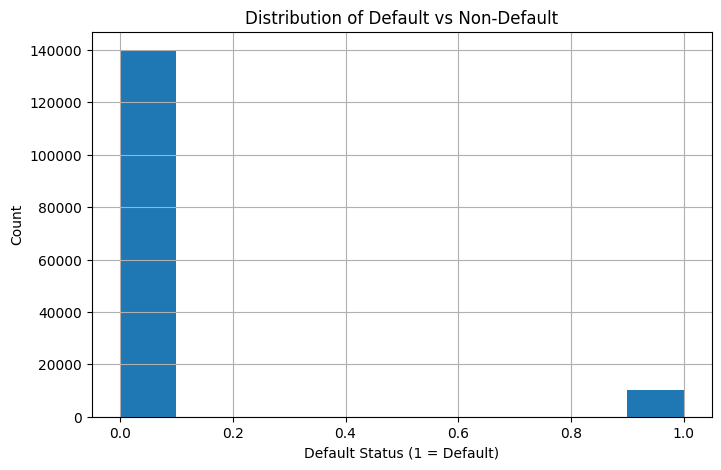

Class Distribution:
No Default: 93.3%
Default: 6.7%


In [65]:
# Visualize the distribution of the features
plt.figure(figsize=(8, 5))
data['SeriousDlqin2yrs'].hist()
plt.title('Distribution of Default vs Non-Default')
plt.xlabel('Default Status (1 = Default)')
plt.ylabel('Count')
plt.show()

print("Class Distribution:")
print(f"No Default: {(data['SeriousDlqin2yrs']==0).sum()/len(data)*100:.1f}%")
print(f"Default: {(data['SeriousDlqin2yrs']==1).sum()/len(data)*100:.1f}%")

This Histogram is displaying the variable we are trying to predict `SeriousDlqin2yrs`. Notice how there is significantly more data samples for Non-Defaulters(Class-0) than Defaulters(Class-1).

#### Why Class Imbalance Matters

Imagine you're a doctor screening for a rare disease that affects 1% of the population. If you simply told every patient "you're healthy," you'd be right 99% of the time! But this would be a terrible screening method - you'd miss every single case of the disease.

Credit risk assessment faces the same challenge:
- Simply predicting "no default" for everyone would give 93.3% accuracy
- But this would completely fail at the main task: identifying risky loans
- The rare events (defaults) are often the most important to predict

#### Impact on Model Learning

Class imbalance affects how models learn:

1. **Training Data Exposure**
   - Models see many more examples of non-defaults
   - They get less practice identifying default patterns
   - Like a doctor who rarely sees cases of a rare disease

2. **Decision Boundaries**
   - Models try to minimize overall error
   - Without adjustment, they favor majority class predictions
   - Like our "predict healthy for everyone" example

3. **Performance Metrics**
   - Standard accuracy becomes misleading
   - Need to focus on minority class performance
   - Like measuring a disease screening test by its ability to catch actual cases

### Real-World Significance

In credit risk assessment, the costs of different types of errors vary greatly:

1. **False Negatives** (Missing a Default)
   - Approving a loan that defaults
   - Can lead to significant financial losses
   - Usually more costly than false positives

2. **False Positives** (False Alarm)
   - Declining a loan that would have been repaid
   - Loses potential business
   - Usually less costly than false negatives

Therefore, we need our models to:
- Pay special attention to the minority class
- Balance different types of errors
- Maintain reasonable overall accuracy

#### Solution Approaches

Modern machine learning handles class imbalance through:

1. **Class Weights**
   - Tell the model that minority class errors are more important
   - Like telling a doctor "better safe than sorry" with rare disease screening

2. **Evaluation Metrics**
   - Use metrics that consider both classes equally
   - Focus on model's ability to identify defaults
   - Standard in modern machine learning libraries

### Feature Scaling

### Recap: Why We Need Scaling
As we discussed in our feature engineering fundamentals, scaling is crucial when:
1. Features have different units (dollars vs. counts vs. ratios)
2. Algorithms are sensitive to feature scales (like our upcoming KNN model)
3. We want all features to contribute equally to the model

We're using MinMaxScaler because:
- It transforms all features to [0,1] range
- Preserves zero values and sparsity
- Handles outliers better than StandardScaler for this dataset

In [66]:
# Calculate basic statistics for each feature
feature_stats = pd.DataFrame({
    'min': X.min(axis=0),
    'max': X.max(axis=0),
    'range': X.max(axis=0) - X.min(axis=0),
    'mean': X.mean(axis=0),
    'std': X.std(axis=0)
}, index=X_cols)

print("Feature Statistics:")
display(feature_stats)

Feature Statistics:


,min,max,range,mean,std
RevolvingUtilizationOfUnsecuredLines,0.0,50708.0,50708.0,6.048438,249.754538
age,0.0,109.0,109.0,52.295207,14.771817
NumberOfTime30-59DaysPastDueNotWorse,0.0,98.0,98.0,0.421033,4.192767
DebtRatio,0.0,329664.0,329664.0,353.005076,2037.811730
MonthlyIncome,0.0,3008750.0,3008750.0,6418.454920,12890.352574
NumberOfOpenCreditLinesAndLoans,0.0,58.0,58.0,8.452760,5.145934
NumberOfTimes90DaysLate,0.0,98.0,98.0,0.265973,4.169290
NumberRealEstateLoansOrLines,0.0,54.0,54.0,1.018240,1.129767
NumberOfTime60-89DaysPastDueNotWorse,0.0,98.0,98.0,0.240387,4.155166
NumberOfDependents,0.0,20.0,20.0,0.737413,1.107018


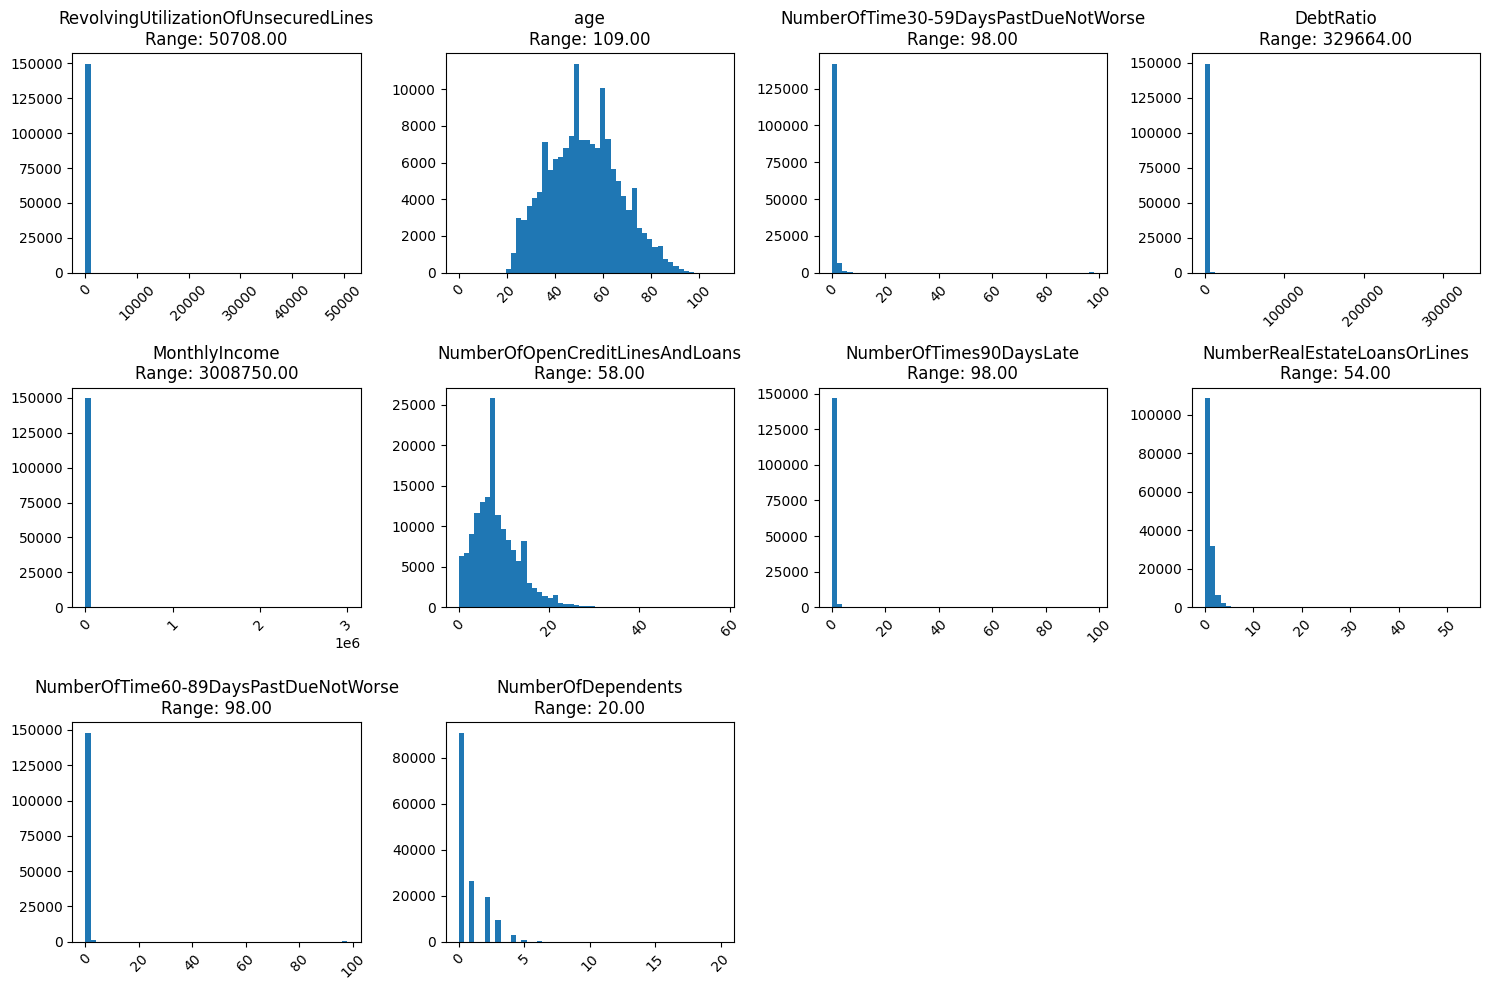

In [67]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_cols):
    plt.subplot(3, 4, i+1)
    plt.hist(X[:, i], bins=50)
    plt.title(f'{column}\nRange: {feature_stats.loc[column, "range"]:.2f}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Insights from Feature Distributions

Looking at our histograms, we can identify several important patterns that inform our scaling strategy:

1. **Extreme Range Differences**:
   - MonthlyIncome spans thousands of dollars
   - RevolvingUtilization ranges from 0 to >1
   - Age spans only 20-100
   - These vastly different scales would cause some features to dominate others without scaling

2. **Heavy-Tailed Distributions**:
   - MonthlyIncome shows a long right tail
   - RevolvingUtilization has extreme outliers
   - DebtRatio includes some very high values
   - MinMaxScaler will compress these long tails, which might be beneficial for our models

3. **Discrete vs Continuous Features**:
   - NumberOfDependents and various payment history features are discrete counts
   - Age and MonthlyIncome are continuous
   - Scaling will preserve the discrete nature while making values comparable

4. **Zero-Inflated Features**:
   - Payment history features (30-59, 60-89, 90+ days late) have many zeros
   - MinMaxScaler will preserve these zero values while scaling the non-zero range
   - This is important for maintaining the significance of "never late" vs "sometimes late"

These observations confirm that MinMaxScaler is appropriate because:
- It will handle the extreme range differences effectively
- It preserves zero values in our payment history features
- It compresses outliers without removing their relative importance
- It puts all features on a [0,1] scale while maintaining their distribution shapes

In [68]:
# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Features scaled.")

Features scaled.


## Model Development and Evaluation

### Custom Evaluation Metric

First, we need to decide how we will handle the class imbalance issue.

Recall that one of the solutions was to make prediction mistakes in the minority class more severe than the majority class. This is what we will implement. Don't worry about the math behind it, just know it is essentially increasing the penalty on accuracy score for mistakes made in the Defaulting class

In [69]:
def weighted_accuracy(confusion):
    """Calculate weighted accuracy for imbalanced classification."""
    M = confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k] /= M[k].sum() + 1e-8    
    acc = M.diagonal().sum() / M.sum()
    return acc

This is a simple function that we will use to create our model summaries. I wrote it up here so I would not have to repeatedly write this code for each model. Again, don't worry about the code. Just focus on its output whenever you see this function is called.

In [70]:
def evaluate_model(model, X, y, title="Model Performance"):
    """Evaluate model and display results."""
    y_pred = model.predict(X)
    conf_matrix = confusion_matrix(y, y_pred)
    acc = weighted_accuracy(conf_matrix)
    
    print(f"\n{title}")
    print(f"Weighted Accuracy: {acc:.4f}")
    print("\nConfusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    return acc

From this point on, I will not be explaining much of what is going on. This blog's main goal was to teach you about class imbalance in datasets and how to handle it. These models are covered in more depth in their own blog posts.

### Baseline Model: Logistic Regression


Logistic Regression Performance
Weighted Accuracy: 0.6943

Confusion Matrix:


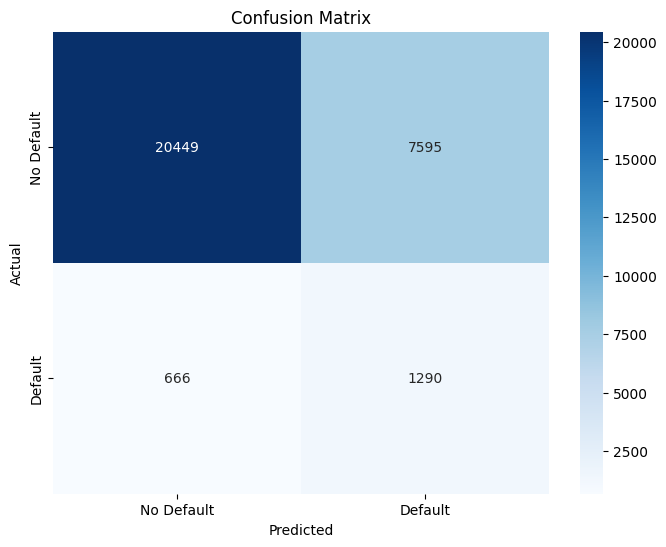


Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     28044
         1.0       0.15      0.66      0.24      1956

    accuracy                           0.72     30000
   macro avg       0.56      0.69      0.53     30000
weighted avg       0.91      0.72      0.79     30000



In [71]:
# Train and evaluate logistic regression
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)
lr_acc = evaluate_model(lr_model, X_test, y_test, "Logistic Regression Performance")

Let me quickly refresh your memory about confusion matrices from our earlier ML fundamentals discussions.

Think of a confusion matrix like a report card showing how well our model's predictions match reality. For credit risk:

```
                 Predicted
Actual    No Default | Default
No Default    TN     |   FP
Default       FN     |   TP
```

Where:
- TN (True Negative): Correctly identified non-defaults
- FP (False Positive): Incorrectly flagged as defaults
- FN (False Negative): Missed defaults
- TP (True Positive): Correctly identified defaults

In credit risk context:
- FN (missing a default) is usually most costly - it means losing money on a bad loan
- FP (falsely predicting default) is less costly - it means missing a business opportunity
- The diagonal (TN and TP) shows our correct predictions

When we see the numbers in our plots:
- Higher numbers on the diagonal = better performance
- Pay special attention to the bottom row (actual defaults) due to class imbalance
- We want to maximize TP without causing too many FP

### Decision Tree with Optimization

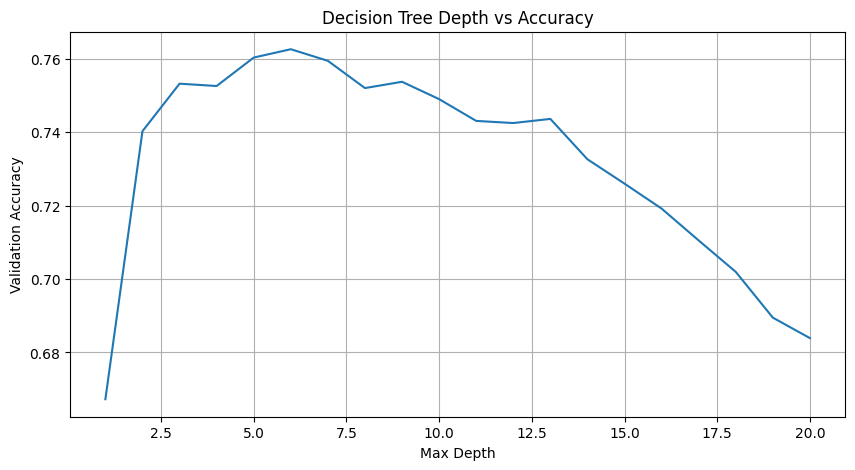


Decision Tree Performance
Weighted Accuracy: 0.7527

Confusion Matrix:


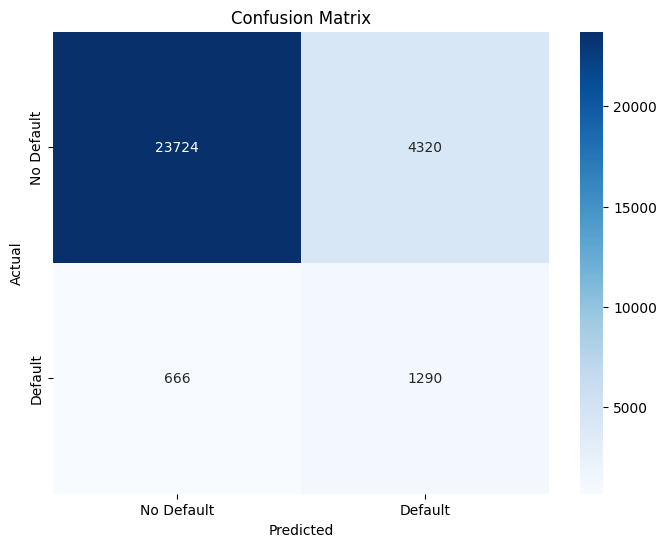


Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.90     28044
         1.0       0.23      0.66      0.34      1956

    accuracy                           0.83     30000
   macro avg       0.60      0.75      0.62     30000
weighted avg       0.92      0.83      0.87     30000



In [72]:
# Grid search for optimal max_depth
depths = range(1, 21)
dt_val_scores = []

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42)
    dt.fit(X_train, y_train)
    y_val_pred = dt.predict(X_val)
    dt_val_scores.append(weighted_accuracy(confusion_matrix(y_val, y_val_pred)))

# Plot validation scores
plt.figure(figsize=(10, 5))
plt.plot(depths, dt_val_scores)
plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.title('Decision Tree Depth vs Accuracy')
plt.grid(True)
plt.show()

# Train final model with best depth
best_depth = depths[np.argmax(dt_val_scores)]
dt_model = DecisionTreeClassifier(max_depth=best_depth, class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
dt_acc = evaluate_model(dt_model, X_test, y_test, "Decision Tree Performance")

### Random Forest With Grid Search

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}

Random Forest Performance
Weighted Accuracy: 0.7589

Confusion Matrix:


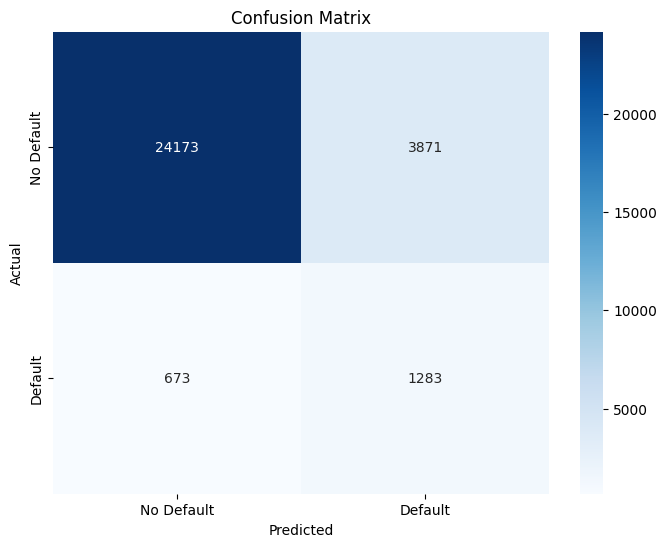


Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91     28044
         1.0       0.25      0.66      0.36      1956

    accuracy                           0.85     30000
   macro avg       0.61      0.76      0.64     30000
weighted avg       0.93      0.85      0.88     30000



In [73]:
# Define parameter grid
param_grid = {
    'max_depth': [1, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search
rf_base = RandomForestClassifier(n_estimators=20, class_weight='balanced', random_state=42)
grid_search = GridSearchCV(
    rf_base, param_grid, cv=5,
    scoring='balanced_accuracy', n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate final model
rf_model = grid_search.best_estimator_
rf_acc = evaluate_model(rf_model, X_test, y_test, "Random Forest Performance")

### Model Comparison

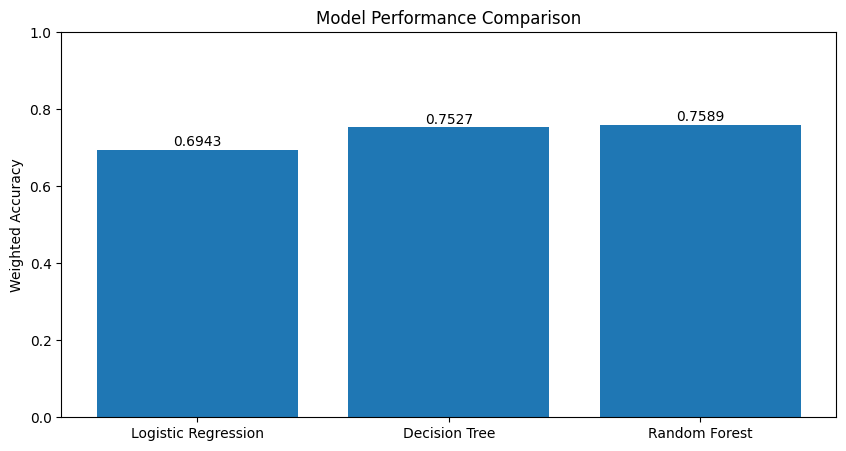

In [74]:
# Compare model performances
models = {
    'Logistic Regression': lr_acc,
    'Decision Tree': dt_acc,
    'Random Forest': rf_acc
}

plt.figure(figsize=(10, 5))
plt.bar(models.keys(), models.values())
plt.title('Model Performance Comparison')
plt.ylabel('Weighted Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(models.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

## Conclusion: Handling Class Imbalance in Credit Risk

### Class Imbalance Insights
Our dataset's natural 93.3% to 6.7% split between non-defaults and defaults highlighted critical aspects of imbalanced learning:

1. **Standard Accuracy is Misleading**
   - A naive model predicting "no default" for everyone would achieve 93.3% accuracy
   - Our weighted accuracy metric provided a more realistic view of model performance
   - This reinforces why proper evaluation metrics are crucial for imbalanced datasets

2. **Business Reality Matters**
   - The imbalance reflects real-world credit default rates
   - Missing defaults (minority class) is more costly than false alarms
   - Models must balance overall accuracy with minority class detection

### Model Performance
Our three models showed different strengths in handling the imbalanced data:

1. **Logistic Regression**: 69.4% weighted accuracy
   - Provided a solid baseline
   - Struggled with identifying defaults
   - Showed the limitations of linear decision boundaries

2. **Decision Tree**: 75.2% weighted accuracy
   - Better at catching defaults
   - More interpretable decisions
   - Demonstrated the value of non-linear patterns

3. **Random Forest**: 75.9% weighted accuracy
   - Best overall performance(barely)
   - Strong default detection while maintaining reasonable false positive rate
   - Most robust to the class imbalance(barely)

This progression shows that while simple models can provide decent results, more sophisticated approaches like Random Forest and Decision Tree can better handle the complexities of imbalanced credit risk assessment without sacrificing interpretability.